In [1]:
] activate "C:\Users\Arman Angaji\OneDrive - Universität zu Köln\Dokumente\Uni-Köln\Masterarbeit\Workspace\Julia_Master\MasterProject_Julia"

  Activating environment at `C:\Users\Arman Angaji\OneDrive - Universität zu Köln\Dokumente\Uni-Köln\Masterarbeit\Workspace\Julia_Master\MasterProject_Julia\Project.toml`


In [2]:
using DataFrames, StatsBase, Plots, Statistics, LaTeXStrings

include("Turnover.jl")
include("test.jl")
using .Turnover

using TumorGrowth: DataFrame, clones_by_mutations, nonspatial, nonspatial!

Test Summary:             | Pass  Total
Applying turnover methods |    5      5


In [7]:
function rerun(until; params...)
    try
        out = nonspatial(until; params...)
        return out
    catch e
        e == ErrorException("Tumor died") || rethrow()
        return rerun(until; params... )
    end
end

rerun (generic function with 1 method)

In [144]:
@btime begin 
    unique!(getfield.(rerun($5000; b =$b, d = $d, μ = $μ)[:tumor],:mutations))
end;

  11.518 ms (93817 allocations: 6.14 MiB)


In [6]:
using BenchmarkTools
b, d, μ = 1., 0.8, 0.1
@btime neutral_growth($5000; b =$b, d = $d, μ = $μ, return_obs=$true, showprogress=false)
@btime neutral_growth($5000; b =$b, d = $d, μ = $μ, return_obs=$false, showprogress=false);

  707.977 ms (2456184 allocations: 351.05 MiB)
  170.280 ms (784087 allocations: 260.19 MiB)


In [3]:
b, d, μ = 1., 0.8, 0.1
tumor, obs, N, t = neutral_growth(5000; b = b, d = d, μ = μ, return_obs=true)
tumor, obs, N, t = neutral_growth!(tumor, obs, 10000; Nthresh=5000, b = b, d = d, μ = μ, t=t)
N, t

Progress: N  8840 	 Time: 0:00:00

(10000, 31.779263593907437)

In [153]:
tumor = DataFrame(mutations = unique!(getfield.(rerun(5000; b =b, d = d, μ = μ)[:tumor],:mutations)));

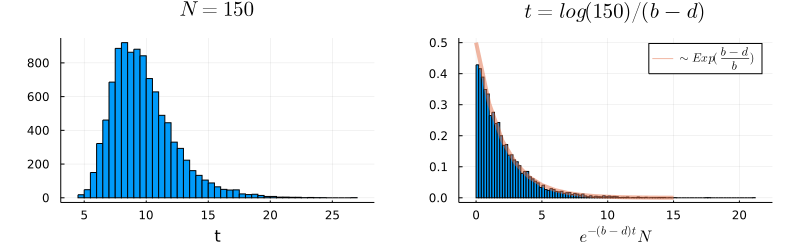

In [4]:
b, d, μ = 1., 0.5, 0.1
p = plot(layout=(1,2), size=(800,250), margin=5Plots.mm)
times = [ neutral_growth(150; b = b, d = d, μ = μ)[:t] for _=1:10000 ]
histogram!(p[1], times, xlab=:t, lab="", title=L"N=150")

T = log(150)/(b-d)
sizes = [ neutral_growth(Inf, T; b = b, d = d, μ = μ)[:N] for _=1:10000 ]
histogram!(p[2], sizes / exp((b-d)*T), lab="", xlab=L"e^{-(b-d)t}N", normalize=true, title=L"t=log(150)/(b-d)")
plot!(p[2], 0:15, n-> (b-d)/b * exp( -(b-d)/b * n), lab=L"\sim Exp( \frac{b-d}{b})", lw=4., alpha=0.5)

### Turnover

In [13]:
sim = include("turnover_data/estranged_turnover_v2.jl")
expect = include("turnover_data/expected_estranged_turnover_v2.jl")
expect_Tcutoff = include("turnover_data/expected_estranged_turnover_v2_Tcutoff.jl")
sim[1]

Dict{Symbol, Any} with 8 entries:
  :std      => [0.05114, 0.0573, 0.05859, 0.06222, 0.07761, 0.0776, 0.0883, 0.0…
  :b        => 1.0
  :N        => 2000
  :Ncutoff  => 200
  :μ        => 0.3
  :reps     => 400
  :turnover => [0.04292, 0.06027, 0.07773, 0.09042, 0.10673, 0.13364, 0.1645, 0…
  :d        => [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.5…

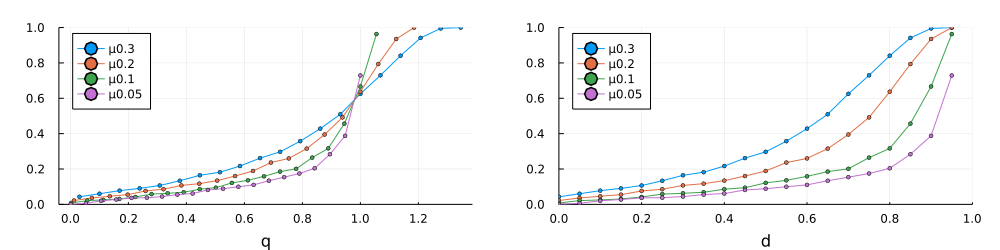

In [10]:
p = plot(layout=(1,2), size=(1000,250), legend=:topleft, margin=5Plots.mm, ylims=(0,1))
for res in sim
    ds = res[:d]
    qs = q.(ds; b=res[:b], μ=res[:μ])
    plot!(p[1], qs ,res[:turnover], xlab=:q, lab="μ$(res[:μ])", marker=:o, ms=2.)
    plot!(p[2], ds ,res[:turnover], xlab=:d, lab="μ$(res[:μ])", marker=:o, ms=2., xlims=(0,1))
end
plot!()

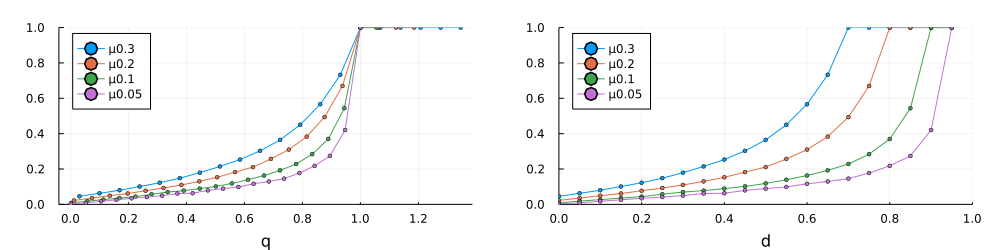

In [43]:
p = plot(layout=(1,2), size=(1000,250), legend=:topleft, margin=5Plots.mm, ylims=(0,1))
for res in expect
    ds = res[:d]
    qs = q.(ds; b=res[:b], μ=res[:μ])
    plot!(p[1], qs ,res[:turnover], xlab=:q, lab="μ$(res[:μ])", marker=:o, ms=2.)
    plot!(p[2], ds ,res[:turnover], xlab=:d, lab="μ$(res[:μ])", marker=:o, ms=2., xlims=(0,1))
end
plot!()

In [108]:
turnover(q; μ) = q/(1-q) * μ/( (1-μ)^2+ μ/(1-q) )

turnover (generic function with 1 method)

#### Measured vs Theory

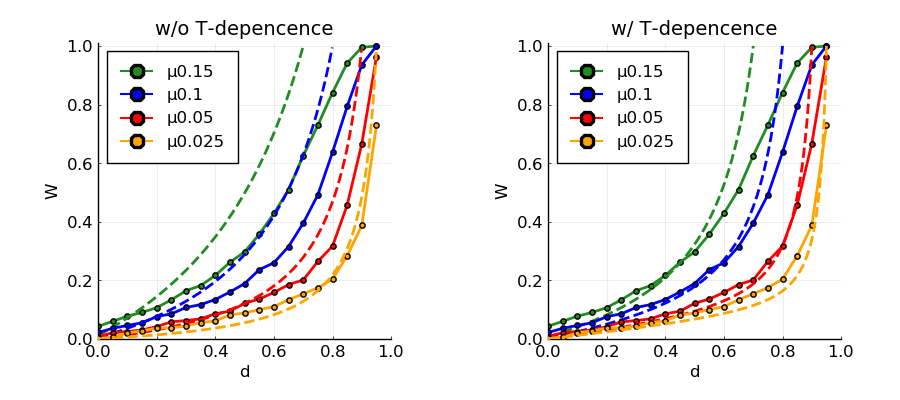

In [109]:
p = plot(layout=(1,2), size=(900,400), legend=:topleft, margin=5Plots.mm, aspect_ratio=1,
        xaxis = ("d", (0, 1.01)), yaxis = ("W", (0, 1.01)), yguidefontrotation=-0,
        legendfont = (12), guidefont = (12), tickfont = (12), xticks=0.:0.2:1., yticks=0.:0.2:1.)

colors = [:forestgreen,:blue,:red,:orange]
for (i,res) in enumerate(sim)
    b, μ, N = res[:b],res[:μ],res[:Ncutoff]
    ds = res[:d]
    qs = q.(ds; b=b, μ=μ)
    plot!(p[1], ds ,res[:turnover], xlab=:d, lab="μ$(μ/2)", marker=:o, ms=4., xlims=(0,1), lw=2., c=colors[i], title="w/o T-depencence")
    plot!(p[2], ds ,res[:turnover], xlab=:d, lab="μ$(μ/2)", marker=:o, ms=4., xlims=(0,1), lw=2., c=colors[i], title="w/ T-depencence")
    
    ds = 0.0:0.001:b*(1-μ)
    qs = q.(ds; b=b, μ=μ)
    plot!(p[1], ds ,turnover.(qs; μ=μ), lab="", lw=2., style=:dash, c=colors[i])
    plot!(p[2], ds ,[ Turnover.W_estranged(d; b=b, μ=μ, T=log(N)/(1. -d)) for d in ds], lab="", lw=2., style=:dash, c=colors[i])

end
plot!()

#### Expected ($q^n$) vs Theory

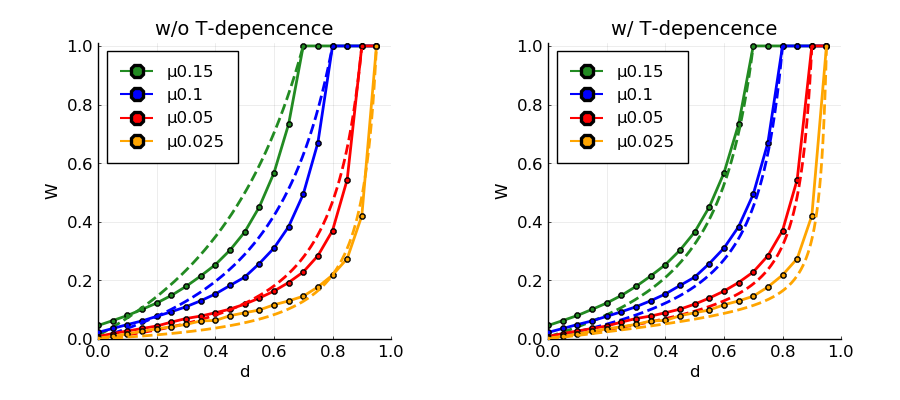

In [111]:
p = plot(layout=(1,2), size=(900,400), legend=:topleft, margin=5Plots.mm, aspect_ratio=1,
        xaxis = ("d", (0, 1.01)), yaxis = ("W", (0, 1.01)), yguidefontrotation=-0,
        legendfont = (12), guidefont = (12), tickfont = (12), xticks=0.:0.2:1., yticks=0.:0.2:1.)

colors = [:forestgreen,:blue,:red,:orange]
for (i,res) in enumerate(expect)
    b, μ, N = res[:b],res[:μ],res[:Ncutoff]
    ds = res[:d]
    qs = q.(ds; b=b, μ=μ)
    plot!(p[1], ds ,res[:turnover], xlab=:d, lab="μ$(μ/2)", marker=:o, ms=4., xlims=(0,1), lw=2., c=colors[i], title="w/o T-depencence")
    plot!(p[2], ds ,res[:turnover], xlab=:d, lab="μ$(μ/2)", marker=:o, ms=4., xlims=(0,1), lw=2., c=colors[i], title="w/ T-depencence")
    
    ds = 0.0:0.001:b*(1-μ)
    qs = q.(ds; b=b, μ=μ)
    plot!(p[1], ds ,turnover.(qs; μ=μ), lab="", lw=2., style=:dash, c=colors[i])
    plot!(p[2], ds ,[ Turnover.W_estranged(d; b=b, μ=μ, T=log(N)/(1. -d)) for d in ds], lab="", lw=2., style=:dash, c=colors[i])
#     plot!(ds ,[ W(d; b=b, μ=μ, T=20.) for d in ds], lab="μ$(μ) T-dep")
end
plot!()

#### Expected ($q^n$) with T cutoff vs Theory

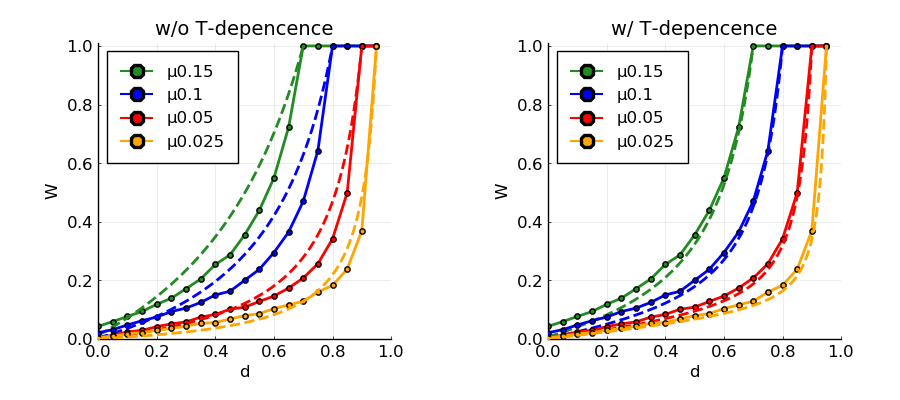

In [112]:
p = plot(layout=(1,2), size=(900,400), legend=:topleft, margin=5Plots.mm, aspect_ratio=1,
        xaxis = ("d", (0, 1.01)), yaxis = ("W", (0, 1.01)), yguidefontrotation=-0,
        legendfont = (12), guidefont = (12), tickfont = (12), xticks=0.:0.2:1., yticks=0.:0.2:1.)

colors = [:forestgreen,:blue,:red,:orange]
for (i,res) in enumerate(expect_Tcutoff)
    b, μ, N = res[:b],res[:μ],res[:Ncutoff]
    ds = res[:d]
    qs = q.(ds; b=b, μ=μ)
    plot!(p[1], ds ,res[:turnover], xlab=:d, lab="μ$(μ/2)", marker=:o, ms=4., xlims=(0,1), lw=2., c=colors[i], title="w/o T-depencence")
    plot!(p[2], ds ,res[:turnover], xlab=:d, lab="μ$(μ/2)", marker=:o, ms=4., xlims=(0,1), lw=2., c=colors[i], title="w/ T-depencence")
    
    ds = 0.0:0.001:b*(1-μ)
    qs = q.(ds; b=b, μ=μ)
    plot!(p[1], ds ,turnover.(qs; μ=μ), lab="", lw=2., style=:dash, c=colors[i])
    plot!(p[2], ds ,[ Turnover.W_estranged(d; b=b, μ=μ, T=log(N)/(1. -d)) for d in ds], lab="", lw=2., style=:dash, c=colors[i])
#     plot!(ds ,[ W(d; b=b, μ=μ, T=20.) for d in ds], lab="μ$(μ) T-dep")
end
plot!()

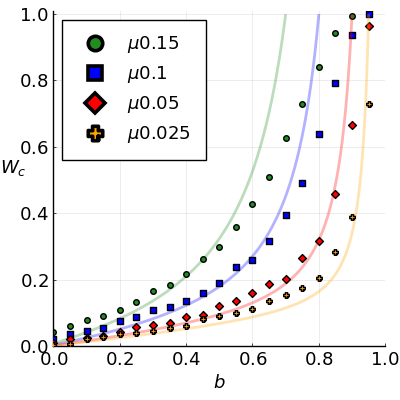

In [38]:
pyplot()
p = plot(size=(400,400), legend=:topleft, margin=0Plots.mm, aspect_ratio=1,
        xaxis = (L"b", (0, 1.01)), yaxis = (L"W_c", (0, 1.01)), yguidefontrotation=-90,
        legendfont = (13), guidefont = (13), tickfont = (13), xticks=0.:0.2:1., yticks=0.:0.2:1.)

colors = [:forestgreen,:blue,:red,:orange]
shapes = [:c, :sq, :d, :cross]
# for (i,res) in enumerate(expect_Tcutoff)
for (i,res) in enumerate(sim)
    b, μ, N = res[:b],res[:μ],res[:Ncutoff]
    
    ds = 0.0:0.001:b*(1-μ)
    plot!(ds ,[ Turnover.W_estranged(d; b=b, μ=μ, T=log(N)/(1. -d)) for d in ds], lab="", lw=2., style=:solid, c=colors[i], alpha=0.3)
    
    scatter!(res[:d] ,res[:turnover], lab=L"μ"*"$(μ/2)", ms=4., xlims=(0,1), lw=2., c=colors[i], markershape=shapes[i])
end
plot!()

In [40]:
# savefig("turnover_plots/haplotype_turnover_expected.pdf")
# savefig("turnover_plots/haplotype_turnover_measured.pdf")

#### Measured vs Theory

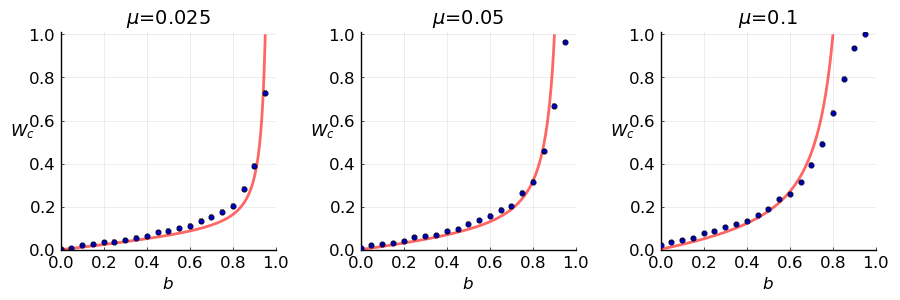

In [24]:
pyplot()
p = plot(layout = (1,3), size=(900,300), legend=:none, margin=2Plots.mm, aspect_ratio=1,
        xaxis = (L"b", (0, 1)), yaxis = (L"W_c", (0, 1.01)), yguidefontrotation=-90,
        guidefont = (12), tickfont = (12), legendfont=(12), xticks=0.:0.2:1., yticks=0.:0.2:1.)
for (i,res) in enumerate(sim[4:-1:2])
        
    b, μ, N = res[:b],res[:μ],res[:Ncutoff]
    
    ds = 0.0:0.001:b*(1-μ)
    qs = q.(ds; b=b, μ=μ)
    
    plot!(p[i], ds ,[ Turnover.W_estranged(d; b=b, μ=μ, T=log(N)/(1. -d)) for d in ds], lw=2., c=:red, alpha=0.6)
    

    scatter!(p[i], res[:d] ,res[:turnover] , title=L"μ"*"=$(μ/2)",
        marker=:o, ms=4., c=:blue, alpha=1., markerstrokewidth=0.5)
    plot!(p[i], res[:d],res[:turnover] , yerror = res[:std] ./ sqrt(res[:reps]),
       ms=3., alpha=0.3, markerstrokewidth=0.9, fillalpha=1., lw=0.)
end
plot!()

In [26]:
# savefig("turnover_plots/estranged_turnover_measured_series.png")

#### Expected ($q^n$) vs Theory

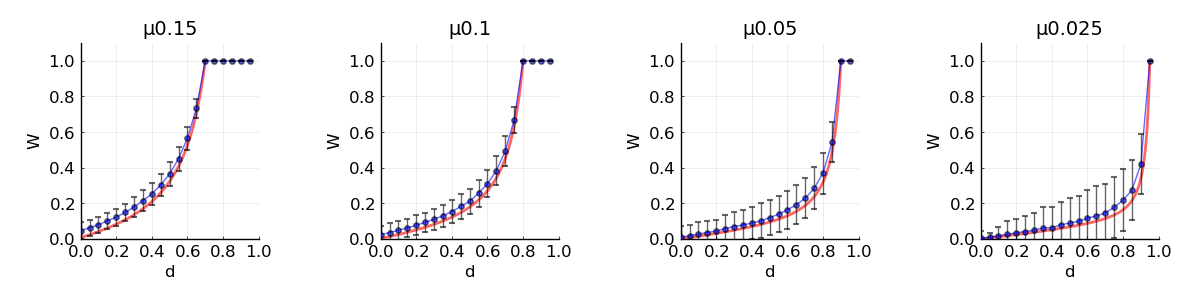

In [117]:
pyplot()
expect = include("turnover_data/expected_estranged_turnover_v2.jl")
p = plot(layout = (1,4), size=(1200,300), legend=:none, margin=5Plots.mm, aspect_ratio=1,
        xaxis = ("d", (0, 1)), yaxis = ("W", (0, 1.1)), yguidefontrotation=-0,
        guidefont = (12), tickfont = (12), xticks=0.:0.2:1., yticks=0.:0.2:1.)
for (i,res) in enumerate(expect)
        
    b, μ, N = res[:b],res[:μ],res[:Ncutoff]
    
    ds = 0.0:0.001:b*(1-μ)
    qs = q.(ds; b=b, μ=μ)
    
#     plot!(p[i],ds ,turnover.(qs; μ=μ), lw=2., c=:red, alpha=0.6)
    plot!(p[i], ds ,[ Turnover.W_estranged(d; b=b, μ=μ, T=log(N)/(1. -d)) for d in ds], lw=2., c=:red, alpha=0.6)
    

    ds = res[:d]
    qs = q.(ds; b=b, μ=μ)
    plot!(p[i],ds ,res[:turnover], marker=:o, ms=4., title="μ$(μ/2)", c=:blue, alpha=0.6, yerror=res[:std])

end
plot!()

#### Expected ($q^n$) with T cutoff vs Theory

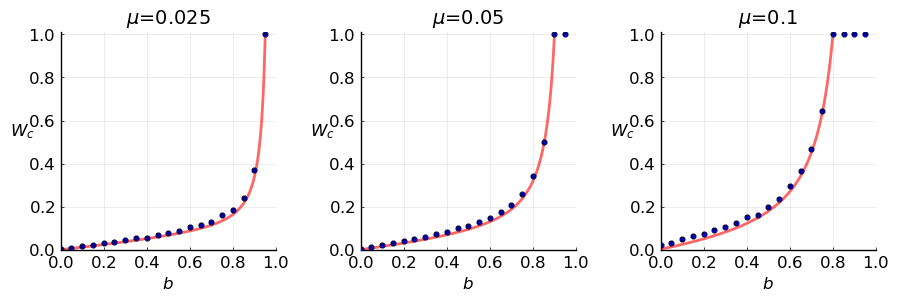

In [18]:
pyplot()
p = plot(layout = (1,3), size=(900,300), legend=:none, margin=2Plots.mm, aspect_ratio=1,
        xaxis = (L"b", (0, 1)), yaxis = (L"W_c", (0, 1.01)), yguidefontrotation=-90,
        guidefont = (12), tickfont = (12), legendfont=(12), xticks=0.:0.2:1., yticks=0.:0.2:1.)
for (i,res) in enumerate(expect_Tcutoff[4:-1:2])
        
    b, μ, N = res[:b],res[:μ],res[:Ncutoff]
    
    ds = 0.0:0.001:b*(1-μ)
    qs = q.(ds; b=b, μ=μ)
    
    plot!(p[i], ds ,[ Turnover.W_estranged(d; b=b, μ=μ, T=log(N)/(1. -d)) for d in ds], lw=2., c=:red, alpha=0.6)
    

    scatter!(p[i], res[:d] ,res[:turnover] , title=L"μ"*"=$(μ/2)",
        marker=:o, ms=4., c=:blue, alpha=1., markerstrokewidth=0.5)
    plot!(p[i], res[:d],res[:turnover] , yerror = res[:std] ./ sqrt(res[:reps]),
       ms=3., alpha=0.3, markerstrokewidth=0.9, fillalpha=1., lw=0.)
end
plot!()

In [20]:
savefig("turnover_plots/estranged_turnover_expected_series.png")

#### Expected ($q^n$) vs Measured

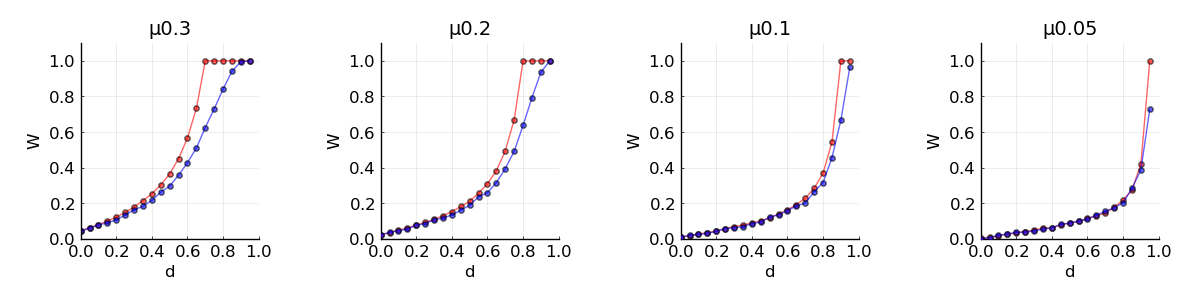

In [112]:
pyplot()
expect = include("turnover_data/expected_estranged_turnover_v2.jl")
sim = include("turnover_data/estranged_turnover_v2.jl")
p = plot(layout = (1,4), size=(1200,300), legend=:none, margin=5Plots.mm, aspect_ratio=1,
        xaxis = ("d", (0, 1)), yaxis = ("W", (0, 1.1)), yguidefontrotation=-0,
        guidefont = (12), tickfont = (12), xticks=0.:0.2:1., yticks=0.:0.2:1.)
for (i,expres) in enumerate(expect)
        
    b, μ, N = expres[:b],expres[:μ],expres[:Ncutoff]

    ds = expres[:d]
    qs = q.(ds; b=b, μ=μ)
    plot!(p[i],ds ,expres[:turnover], marker=:o, ms=4., title="μ$(μ)", c=:red, alpha=0.6)#, yerror=expres[:std])
    
    res = filter(s -> s[:Ncutoff] == expres[:Ncutoff] && s[:μ] == expres[:μ], sim)[1]
    
    b, μ, N = res[:b],res[:μ],res[:Ncutoff]
    ds = res[:d]
    qs = q.(ds; b=b, μ=μ)
    plot!(p[i],ds ,res[:turnover], marker=:o, ms=4., title="μ$(μ)", c=:blue, alpha=0.6)#, yerror=res[:std])

end
plot!()

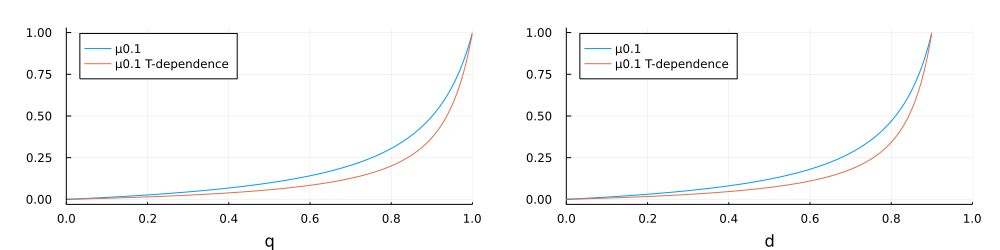

In [135]:
p = plot(layout=(1,2), size=(1000,250), legend=:topleft, margin=5Plots.mm)
b = 1.
μ = 0.1

ds = 0.0:0.001:b*(1-μ)
qs = q.(ds; b=1., μ=μ)
plot!(p[1], qs ,turnover.(qs; μ=μ), xlab=:q, lab="μ$μ", xlims=(0.,1.))
# plot!(p[1], qs ,[ W(d; b=1., μ=μ, T=log(500)/(1. -d)) for d in ds], xlab=:q, lab="μ$μ T-dependence", xlims=(0.,1.))
plot!(p[1], qs ,[ W(d; b=1., μ=μ, T=20.) for d in ds], xlab=:q, lab="μ$μ T-dependence", xlims=(0.,1.))

plot!(p[2], ds ,turnover.(qs; μ=μ), xlab=:d, lab="μ$μ", xlims=(0.,1.))
# plot!(p[2], ds ,[ W(d; b=1., μ=μ, T=log(500)/(1. -d)) for d in ds], xlab=:d, lab="μ$μ T-dependence", xlims=(0.,1.))
plot!(p[2], ds ,[ W(d; b=1., μ=μ, T=20.) for d in ds], xlab=:d, lab="μ$μ T-dependence", xlims=(0.,1.))

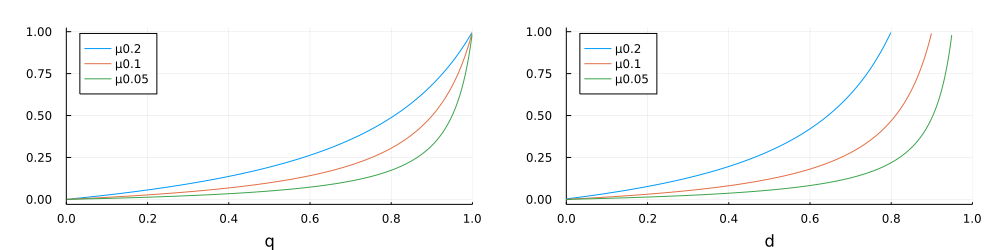

In [46]:
ds = 0.0:0.001:1.

p = plot(layout=(1,2), size=(1000,250), legend=:topleft, margin=5Plots.mm)
for μ in (0.2,0.1,0.05)
    qs = q.(ds; b=1., μ=μ)
    plot!(p[1], qs ,turnover.(qs; μ=μ), xlab=:q, lab="μ$μ", xlims=(0.,1.))
    plot!(p[2], ds ,turnover.(qs; μ=μ), xlab=:d, lab="μ$μ", xlims=(0.,1.))
end
plot!()

### old "mean" theory

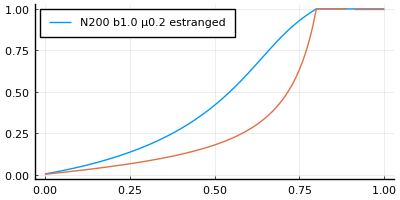

In [64]:
b, μ = 1., 0.2

ds = 0.0:0.01:1.
po = similar(collect(ds))
for (i, d) in enumerate(ds)
    qval = q(d; b=b, μ=μ)
    
    if qval >= 1
        po[i] = 1.
    else
        po[i] = sum( 1 - qval^( (Ncutoff/n)^(1-b*μ/(b-d)) ) for n = 1:Ncutoff)
        po[i] *= qval/(1-qval)
        po[i] /= sum((Ncutoff/n)^(1-b*μ/(b-d)) for n = 1:Ncutoff)
    end
end

# po = [ q >= 1. ? 1. : q/(1-q) * sum( 1 - q^(Ncutoff/n) for n = 1:Ncutoff) / (Ncutoff * sum(1/n for n = 1:Ncutoff)) for q in ds ./ (b*(1-μ))]

p_estr = plot(ds, po, lab="N$Ncutoff b$b μ$μ estranged", legend=:topleft, size=(400,200))
plot!(ds, [ min(1., W(d; b=b, μ=μ, T = log(Ncutoff)/(b-d))) for d=ds], lab="")

### n estimate

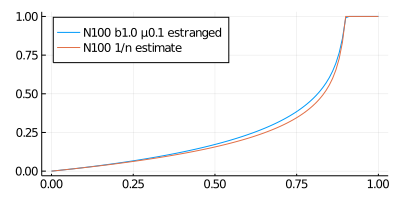

In [181]:
b = 1.

pn = [q >= 1. ? 1. : sum( q^n*1/n for n=1:Ncutoff) / sum( 1/n for n=1:Ncutoff) for q in ds ./ (b*(1-μ))]
plot!(p_estr, ds, pn, lab="N$Ncutoff 1/n estimate", legend=:topleft)

# pn = [d / (b*(1-μ)) >= 1. ? 1. : sum( ( d ./ (b*(1-μ)) )^n*pn_estr[i][n] for n=1:length(pn_estr[i])) for (i,d) in enumerate(0.:0.05:0.9)]
# plot!(p_estr, 0.:0.05:0.9, pn, lab="n hist", legend=:topleft)

## haplotype extinction

In [47]:
b, μ = 1., 0.2
N, Ncutoff = 5000, 50
T, Tcutoff = Inf, Inf
Nrange=1000:1000:10000
dp = b*(1-μ)
reps = 100

countextinct = zeros(Float64, reps, length(drange))

# for (i,dp)=enumerate(drange)
for (i,N)=enumerate(Nrange)
    for n=1:reps
        out = neutral_growth(Ncutoff, Tcutoff; b = b, d = dp, μ = μ, return_obs=false, showprogress=false)
        m_cutoff = length(out[:tumor])-1
        out = neutral_growth!(out[:tumor], N, T; b = b, d = dp, μ = μ, t=out[:t], showprogress=false)
        tumor = DataFrame(out[:tumor][2:m_cutoff+1])
        countextinct[n,i] = iszero(m_cutoff) ? missing : count(iszero, tumor.n) / m_cutoff
    end
    
    print("d",dp," ")
    sleep(0.1)
end

d0.8 d0.8 d0.8 d0.8 d0.8 d0.8 d0.8 d0.8 d0.8 d0.8 

In [48]:
q_m = [mean(skipmissing( countextinct[:,i] ) ) for i=1:length(drange)]
q_err = [std(skipmissing(countextinct[:,i]) )/sqrt(count(!ismissing,countextinct[:,i])) for i=1:length(drange)]
round.(q_m, digits=4) |> println
round.(q_err, digits=4) |> println

[0.9231, 0.9394, 0.9416, 0.9396, 0.9479, 0.9562, 0.95, 0.9559, 0.9554, 0.9519, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0062, 0.0042, 0.0044, 0.0041, 0.0036, 0.0032, 0.0035, 0.0035, 0.0036, 0.004, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


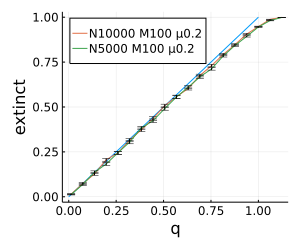

In [59]:
plot([0.,1.], [0.,1.], lab="", legend=:topleft, size=(300,250), xlab="q", ylab="extinct" )
for res in extinct
    plot!(q.(res[:d]; b=res[:b], μ=res[:μ]), res[:q_m], lab="N$(res[:N]) M$(res[:Ncutoff]) μ$(res[:μ])", yerror=res[:q_err])
end
plot!()

In [60]:
extinct = [
Dict( :N => 10000, :Ncutoff => 100, :b => 1.0, :μ => 0.2, :reps => 100,
    :q_m => [0.0144, 0.074, 0.1273, 0.206, 0.2448, 0.3149, 0.3733, 0.4357, 0.5073, 0.5571, 0.6028, 0.6751, 0.7304, 0.7925, 0.8475, 0.9058, 0.948, 0.9877, 0.9993],
    :q_err => [0.0025, 0.0063, 0.0074, 0.008, 0.0086, 0.0086, 0.0095, 0.0098, 0.0084, 0.0088, 0.0082, 0.0077, 0.0071, 0.0058, 0.0044, 0.0033, 0.0022, 0.0012, 0.0002],
    :d => [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9] ),
    
Dict( :N => 5000, :Ncutoff => 100, :b => 1.0, :μ => 0.2, :reps => 100,
    :q_m => [0.0125, 0.0689, 0.1363, 0.1827, 0.2451, 0.3046, 0.3828, 0.4238, 0.4911, 0.5555, 0.6102, 0.6675, 0.7124, 0.7847, 0.8429, 0.893, 0.9456, 0.9812, 0.9987],
    :q_err => [0.0024, 0.0056, 0.008, 0.0083, 0.0083, 0.0095, 0.0091, 0.0095, 0.009, 0.0089, 0.0083, 0.008, 0.0072, 0.0064, 0.005, 0.0035, 0.003, 0.0015, 0.0003],
    :d => [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9] ),
    
];

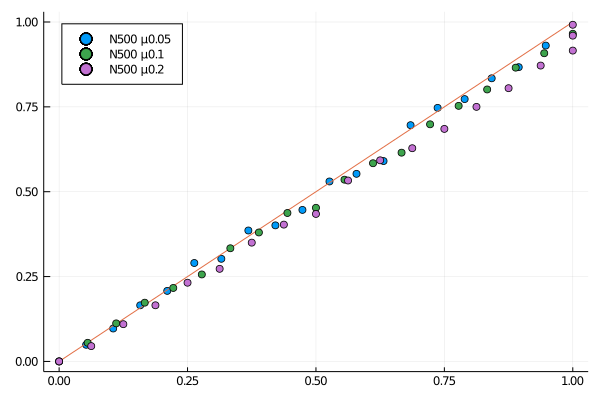

In [35]:
scatter!(q.(drange; b=b, μ=μ), countestr, lab="N$Ncutoff μ$μ")
# plot!([0.,1.], [0.,1.], lab="", legend=:topleft)

# haplotpye parent extinction, turnover

In [5]:
?q

search: q quote quiver quiver! qqbuild QQPair quantile quantile! QuoteNode



```
q(d; b, μ )
```

Function returning the extinction probability for given `d` death-rate, `b` birth-rate and `μ` mutation-rate. <br> **Branchingprocess `v2`**: independent mutation of offspring pair at division. `μ` is the probability of mutation per cell division. The mutation probability per cell division per cell is `μ/2`.


In [ ]:
N, Ncutoff = 2000, 200
T, Tcutoff = Inf, Inf

b, μ = 1., 0.4
drange = 0.0:0.05:0.95

reps = 100
countestr = Matrix{Float64}(undef, length(drange), reps)
countgreens = Matrix{Int}(undef, length(drange), reps)
for (i,dp)=enumerate(drange)
    
    j=1
    while j<=reps
        
        ### simulate and only consider haplotypes born before Ncutoff ###
        
        out = neutral_growth(Ncutoff, Tcutoff; b = b, d = dp, μ = μ, return_obs=false, showprogress=false)
        m_cutoff = length(out[:tumor])-1
        out = neutral_growth!(out[:tumor], N, T; b = b, d = dp, μ = μ, t=out[:t], showprogress=false)
        htumor = DataFrame(out[:tumor][1:m_cutoff+1])
        
        ### get estranged fraction ###
        
#         res = estranged_treeless(filter(h-> !iszero(h.n), htumor))
        res = estranged(htumor)
#         res = estranged_expected(htumor, min(1, q(dp; b=b, μ=μ)), out[:obs][:,1])
        if !isempty(res)
            countestr[i,j], countgreens[i,j] = isempty(res) ? (0., 0.) : (sum(res.isestranged), nrow(res)) # sum(res.isgreen)
            j += 1
        end
    end
    
    print("d",dp," ")
    sleep(0.1)
end

In [ ]:
t = [sum(countestr[i,1:end-1]) / sum(countgreens[i,1:end-1]) for i=1:length(drange)]
sterr = [filter!(!isnan, countestr[i,:] ./ countgreens[i,:]) |> x-> std(x)/sqrt(length(x)) for i=1:length(drange)]
    
round.(t, digits=5) |> println
round.(sterr, digits=5) |> println

In [64]:
# t = [sum(countestr[i,:]) / sum(countgreens[i,:]) for i=1:length(drange)]

# stdevs = [std( filter!(!isnan, countestr[i,:] ./ countgreens[i,:])) for i=1:length(drange)]

# round.(t, digits=5) |> println
# round.(stdevs, digits=5) |> println

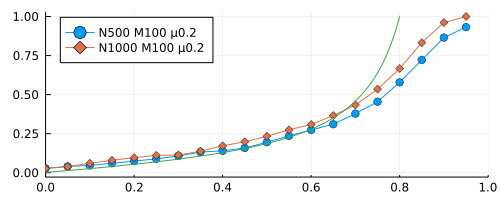

In [187]:
plot(drange, t, lab="N$N M$Ncutoff μ$μ", marker=:o, xlims=(0.,1.), size=(500,200), legend=:topleft)

res = sim[2]
plot!(res[:d], res[:turnover], lab="N$(res[:N]) M$(res[:Ncutoff]) μ$(res[:μ])", marker=:d)

ds = 0.:0.01:b*(1-μ)
plot!(ds, [ Turnover.W_estranged(d; b=b, μ=μ, T=log(Ncutoff)/(1. -d)) for d in ds], lab="", size=(500,200) )

### Expected curve and variability

In [33]:
plot(drange, t, lab="N$N M$Ncutoff μ$μ", xlims=(0.,1.), size=(500,200), legend=:topleft, yerror=sterr)
for (i,d) in enumerate(drange)
    scatter!(fill(d, reps), countestr[i,:] ./ countgreens[i,:], lab="", alpha=0.5, ms=0.1)
end
plot!()

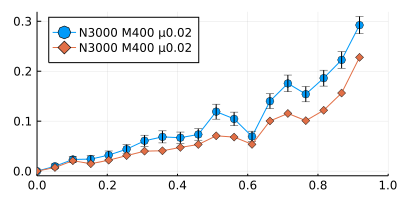

In [178]:
qs = q.(drange; b=b, μ=μ)

t = [mean(filter(!isnan, countestr[i,:] ./ countgreens[i,:])) for i=1:length(drange)]
t_err = [std(filter(!isnan, countestr[i,:] ./ countgreens[i,:])) for i=1:length(drange)] ./ sqrt(reps)

plot(qs, t, yerror = t_err, lab="N$N M$Ncutoff μ$μ", marker=:o, xlims=(0.,1.), size=(400,200), legend=:topleft)

t = [sum(countestr[i,:]) / sum(countgreens[i,:]) for i=1:length(drange)]

plot!(qs, t, lab="N$N M$Ncutoff μ$μ", marker=:d, xlims=(0.,1.))

### Estranged turnover identical for surviving clones or haplotypes 
#### (`q` both in denominator and numerator)

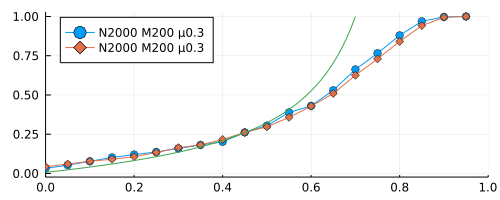

In [16]:
plot(drange, t, lab="N$N M$Ncutoff μ$μ", marker=:o, xlims=(0.,1.), size=(500,200), legend=:topleft)
plot!(sim[1][:d], sim[1][:turnover], lab="N$N M$Ncutoff μ$μ", marker=:d)

ds = 0.:0.01:b*(1-μ)
plot!(ds, [ Turnover.W_estranged(d; b=b, μ=μ, T=log(Ncutoff)/(1. -d)) for d in ds], lab="" )

### Turnover slightly depends on threshold $N_{cutoff}$

In [194]:
data = include("turnover_data/varyN/estranged_varyNdata.jl");

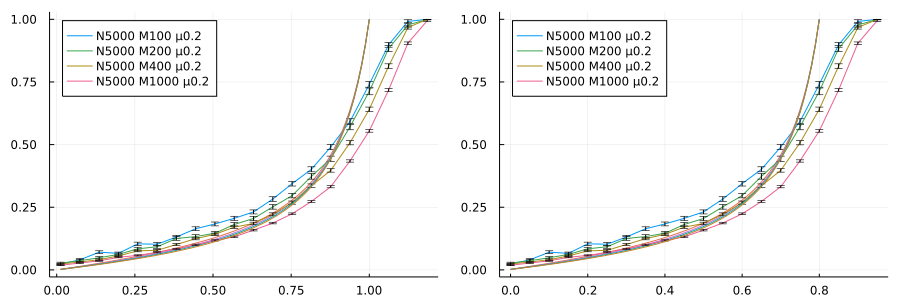

In [193]:
let p= plot(layout=(1,2), size=(900,300), legend=:topleft )
    for res in data[1:4]
        N,Ncutoff,b,μ = res[:N],res[:Ncutoff],res[:b],res[:μ]

        plot!(p[1], q.(res[:d]; b=b, μ=μ), res[:turnover], lab="N$N M$Ncutoff μ$μ", yerror=res[:err])
        plot!(p[2], res[:d], res[:turnover], lab="N$N M$Ncutoff μ$μ", yerror=res[:err])

        ds = 0.:0.01:b*(1-μ)
        plot!(p[1],q.(ds; b=b, μ=μ),[ Turnover.W_estranged(d; b=b, μ=μ, T=log(Ncutoff)/(1. -d)) for d in ds], lab="")
        plot!(p[2],ds,[ Turnover.W_estranged(d; b=b, μ=μ, T=log(Ncutoff)/(1. -d)) for d in ds], lab="")
    end
    display(p)
end

### Haplotypes need time to go extinct

In [190]:
data = include("turnover_data/varyN/estranged_varyNdata.jl");

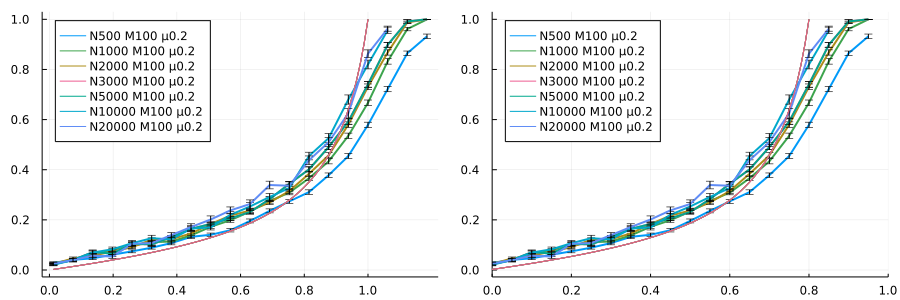

In [189]:
let p= plot(layout=(1,2), size=(900,300), legend=:topleft, xticks=0.:0.2:1., yticks=0.:0.2:1. )
    
    for res in data[7:end]
        N,Ncutoff,b,μ = res[:N],res[:Ncutoff],res[:b],res[:μ]

        plot!(p[1], q.(res[:d]; b=b, μ=μ), res[:turnover], lab="N$N M$Ncutoff μ$μ", yerror=res[:err], lw=2.)
        plot!(p[2], res[:d], res[:turnover], lab="N$N M$Ncutoff μ$μ", yerror=res[:err], lw=2., xlims=(0,1))

        ds = 0.:0.01:b*(1-μ)
        plot!(p[1],q.(ds; b=b, μ=μ),[ Turnover.W_estranged(d; b=b, μ=μ, T=log(Ncutoff)/(1. -d)) for d in ds], lab="")
        plot!(p[2],ds,[ Turnover.W_estranged(d; b=b, μ=μ, T=log(Ncutoff)/(1. -d)) for d in ds], lab="")
    end
    display(p)
end

In [195]:
timedata = include("turnover_data/varyN/estranged_varyTdata.jl");

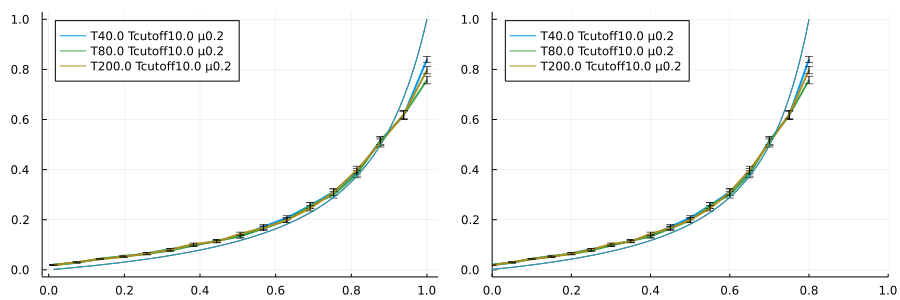

In [197]:
let p= plot(layout=(1,2), size=(900,300), legend=:topleft, xticks=0.:0.2:1., yticks=0.:0.2:1. )
    
    for res in timedata
        T,Tcutoff,b,μ = res[:T],res[:Tcutoff],res[:b],res[:μ]

        plot!(p[1], q.(res[:d]; b=b, μ=μ), res[:turnover], lab="T$T Tcutoff$Tcutoff μ$μ", yerror=res[:err], lw=2.)
        plot!(p[2], res[:d], res[:turnover], lab="T$T Tcutoff$Tcutoff μ$μ", yerror=res[:err], lw=2., xlims=(0,1))

        ds = 0.:0.01:b*(1-μ)
        plot!(p[1],q.(ds; b=b, μ=μ),[ W_estranged(d; b=b, μ=μ, T=Tcutoff) for d in ds], lab="")
        plot!(p[2],ds,[ Turnover.W_estranged(d; b=b, μ=μ, T=Tcutoff) for d in ds], lab="")
    end
    display(p)
end

### frequency cutoff as proxy for size cutoff

In [44]:
N = 4000
Ncutoff = 200

b, μ = 1., 0.2
drange = 0.0:0.05:0.9

reps = 300
cμtestr = Matrix{Float64}(undef, length(drange), reps)
countgreens = Matrix{Float64}(undef, length(drange), reps)
for (i,dp)=enumerate(drange)
    
    for j=1:reps
        
        ### simulate and only consider haplotypes born before Ncutoff ###
        
        htumor = neutral_growth(N; b = b, d = dp, μ = μ)[1] |> DataFrame
        freqs = mfreqs(htumor)
        
#         res = estranged_treeless(filter(h-> !iszero(h.n), htumor))
        res = estranged(htumor)
        
        filter!(m -> freqs[m.mutation] > 1/Ncutoff, res)

        countestr[i,j], countgreens[i,j] = sum(res.isestranged), nrow(res) # sum(res.isgreen)
    end
    
    print("d",dp," ")
    sleep(0.1)
end

d0.0 d0.05 d0.1 d0.15 d0.2 d0.25 d0.3 d0.35 d0.4 d0.45 d0.5 d0.55 d0.6 d0.65 

Progress: N  3958 	 Time: 0:00:00

d0.7 

Progress: N  3613 	 Time: 0:00:00

d0.75 

Progress: N  2619 	 Time: 0:00:00

d0.8 

Progress: N  3231 	 Time: 0:00:00

d0.85 

Progress: N  3883 	 Time: 0:00:00

d0.9 

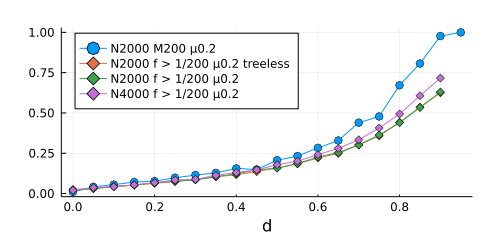

In [45]:
# plot(sim[1][:d], sim[1][:turnover], lab="N2000 M$(sim[1][:N]) μ$(sim[1][:μ])", xlabel=:d, size=(500,250), legend=:topleft, margin=5Plots.mm, marker=:o)

t = [sum(countestr[i,:]) / sum(countgreens[i,:]) for i=1:length(drange)]
plot!(drange, t, lab="N$N f > 1/$Ncutoff μ$μ", marker=:d, xlabel=:d)

In [39]:
# N = 4000; f = 1/200; μ = 0.2
t = [0.02012, 0.03705, 0.04261, 0.05373, 0.0675, 0.0839, 0.08855, 0.11261, 0.13046, 0.14707, 0.1785, 0.20089, 0.24139, 0.28045, 0.33365, 0.4066, 0.49336, 0.60674, 0.7164]
# N = 2000; f = 1/200; μ = 0.2
t = [0.02535, 0.03083, 0.04425, 0.05119, 0.06363, 0.07382, 0.08726, 0.10353, 0.11667, 0.13578, 0.15909, 0.18362, 0.22086, 0.24867, 0.30219, 0.35752, 0.44234, 0.53566, 0.62523]
;

### Mutations at birth Poisson distributed

In [5]:
using TumorGrowth

In [12]:
nonspatial(10000; b=1., d=0.5, μ=2.)

Dict{Symbol, Any} with 4 entries:
  :index    => 20044
  :mutation => 39984
  :tumor    => TumorGrowth.Cell[Cell(267, [0.0], [2, 4, 32, 40, 72, 73, 125, 12…
  :time     => 16.5855

In [13]:
function repeat_at_death(N, Ncutoff; b, d, μ)
    try
        out = nonspatial(Ncutoff; b = b, d = d, μ = μ)
        mcutoff = out[:mutation]
        nonspatial!(out[:tumor], N; b = b, d = d, μ = μ, cur_id=out[:index], cur_mutation=out[:mutation], t=out[:time])
        tumor = DataFrame(out[:tumor])
        return mcutoff, tumor
    catch e
        return repeat_at_death(N, Ncutoff; b=b, d=d, μ=μ)
    end
end

repeat_at_death (generic function with 1 method)

In [34]:
N = 2000
Ncutoff = 200

b, μ = 1., 0.5
drange = 0.0:0.05:0.9

reps = 200
countestr = Matrix{Float64}(undef, length(drange), reps)
countgreens = Matrix{Float64}(undef, length(drange), reps)
for (i,dp)=enumerate(drange)
    
    for j=1:reps
        
        mcutoff, tumor = repeat_at_death(N, Ncutoff; b=b, d=dp, μ=μ)
        htumor = DataFrame(mutations = unique(tumor.mutations))
        
        res = estranged_treeless(htumor)
        
        filter!(m -> m.mutation < mcutoff, res)

        countestr[i,j], countgreens[i,j] = sum(res.isestranged), sum(res.isgreen)
    end
    
    print("d",dp," ")
    sleep(0.1)
end

d0.0 d0.05 d0.1 d0.15 d0.2 d0.25 d0.3 d0.35 d0.4 d0.45 d0.5 d0.55 d0.6 d0.65 d0.7 d0.75 d0.8 d0.85 d0.9 

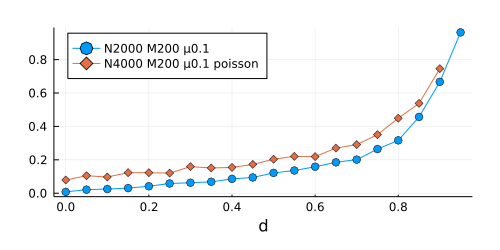

In [21]:
i = 3
plot(sim[i][:d], sim[i][:turnover], lab="N2000 M$(sim[i][:Ncutoff]) μ$(sim[i][:μ])", xlabel=:d, size=(500,250), legend=:topleft, margin=5Plots.mm, marker=:o)

t = [sum(countestr[i,:]) / sum(countgreens[i,:]) for i=1:length(drange)]
plot!(drange, t, lab="N$N M$Ncutoff μ$μ poisson", marker=:d, xlabel=:d)

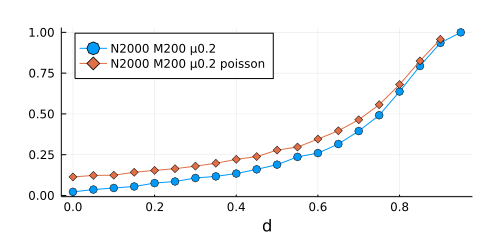

In [24]:
i = 2
plot(sim[i][:d], sim[i][:turnover], lab="N2000 M$(sim[i][:Ncutoff]) μ$(sim[i][:μ])", xlabel=:d, size=(500,250), legend=:topleft, margin=5Plots.mm, marker=:o)

t = [sum(countestr[i,:]) / sum(countgreens[i,:]) for i=1:length(drange)]
plot!(drange, t, lab="N$N M$Ncutoff μ$μ poisson", marker=:d, xlabel=:d)

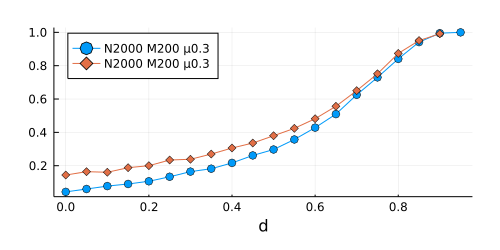

In [33]:
i = 1
plot(sim[i][:d], sim[i][:turnover], lab="N2000 M$(sim[i][:Ncutoff]) μ$(sim[i][:μ])", xlabel=:d, size=(500,250), legend=:topleft, margin=5Plots.mm, marker=:o)

t = [sum(countestr[i,:]) / sum(countgreens[i,:]) for i=1:length(drange)]
plot!(drange, t, lab="N$N M$Ncutoff μ$μ", xlabel=:d, size=(500,250), marker=:d)

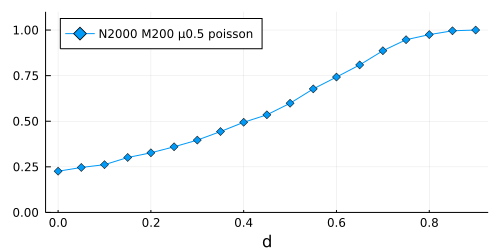

In [38]:
# i = 1
# plot(sim[i][:d], sim[i][:turnover], lab="N2000 M$(sim[i][:Ncutoff]) μ$(sim[i][:μ])", xlabel=:d, size=(500,250), legend=:topleft, margin=5Plots.mm, marker=:o)

t = [sum(countestr[i,:]) / sum(countgreens[i,:]) for i=1:length(drange)]
plot(drange, t, lab="N$N M$Ncutoff μ$μ poisson", xlabel=:d, size=(500,250), marker=:d, legend=:topleft, ylims=(0,1.1))